In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import warnings
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from bs4 import BeautifulSoup
warnings.filterwarnings('ignore')

In [2]:
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('omw-1.4', quiet=True)

True

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, confusion_matrix, classification_report)
import joblib
import pickle

### Part 1: Data understanding

In [6]:
df = pd.read_csv('fake_job_postings.csv')
df.isnull().sum()
df

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17875,17876,Account Director - Distribution,"CA, ON, Toronto",Sales,NaN,Vend is looking for some awesome new talent to...,Just in case this is the first time you’ve vis...,To ace this role you:Will eat comprehensive St...,What can you expect from us?We have an open cu...,0,1,1,Full-time,Mid-Senior level,NaN,Computer Software,Sales,0
17876,17877,Payroll Accountant,"US, PA, Philadelphia",Accounting,NaN,WebLinc is the e-commerce platform and service...,The Payroll Accountant will focus primarily on...,- B.A. or B.S. in Accounting- Desire to have f...,Health &amp; WellnessMedical planPrescription ...,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Internet,Accounting/Auditing,0
17877,17878,Project Cost Control Staff Engineer - Cost Con...,"US, TX, Houston",NaN,NaN,We Provide Full Time Permanent Positions for m...,Experienced Project Cost Control Staff Enginee...,At least 12 years professional experience.Abil...,NaN,0,0,0,Full-time,NaN,NaN,NaN,NaN,0
17878,17879,Graphic Designer,"NG, LA, Lagos",NaN,NaN,NaN,Nemsia Studios is looking for an experienced v...,1. Must be fluent in the latest versions of Co...,Competitive salary (compensation will be based...,0,0,1,Contract,Not Applicable,Professional,Graphic Design,Design,0


In [10]:
# Display dataset shape
print(f"\n📊 Dataset Shape: {df.shape}")
print(f"   - Total Records: {df.shape[0]}")
print(f"   - Total Columns: {df.shape[1]}")
print(f"\n📋 Column List:")
print(df.columns.tolist())


📊 Dataset Shape: (17880, 18)
   - Total Records: 17880
   - Total Columns: 18

📋 Column List:
['job_id', 'title', 'location', 'department', 'salary_range', 'company_profile', 'description', 'requirements', 'benefits', 'telecommuting', 'has_company_logo', 'has_questions', 'employment_type', 'required_experience', 'required_education', 'industry', 'function', 'fraudulent']


In [12]:
# Missing value analysis
print(f"\n Missing Value Count per Column:")
missing_values = df.isnull().sum().sort_values(ascending=False)
missing_percentage = (missing_values / len(df) * 100).round(2)
missing_df = pd.DataFrame({
    'Missing Count': missing_values,
    'Percentage': missing_percentage
})
print(missing_df[missing_df['Missing Count'] > 0])


 Missing Value Count per Column:
                     Missing Count  Percentage
salary_range                 15012       83.96
department                   11547       64.58
required_education            8105       45.33
benefits                      7212       40.34
required_experience           7050       39.43
function                      6455       36.10
industry                      4903       27.42
employment_type               3471       19.41
company_profile               3308       18.50
requirements                  2696       15.08
location                       346        1.94
description                      1        0.01


In [14]:
print(f"\n Distribution of Fraudulent Jobs:")
fraud_counts = df['fraudulent'].value_counts()
print(f"   Real Jobs (0): {fraud_counts[0]} ({fraud_counts[0]/len(df)*100:.2f}%)")
print(f"   Fake Jobs (1): {fraud_counts[1]} ({fraud_counts[1]/len(df)*100:.2f}%)")


 Distribution of Fraudulent Jobs:
   Real Jobs (0): 17014 (95.16%)
   Fake Jobs (1): 866 (4.84%)



 Saved visualization: fraud_distribution.png


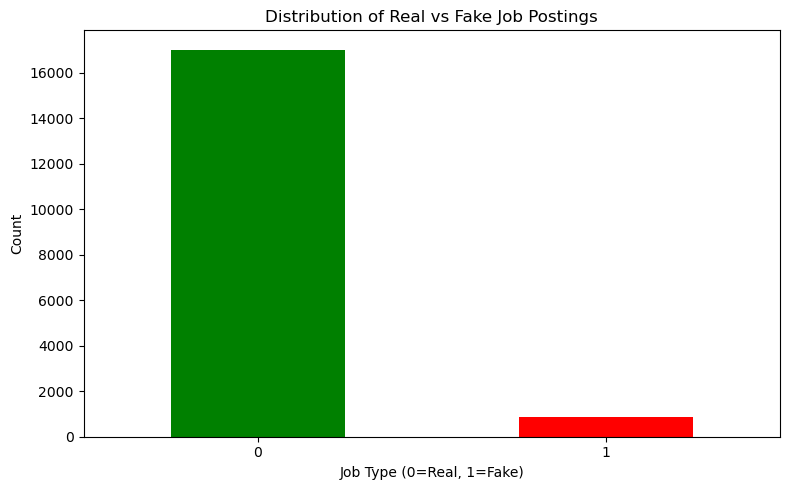

In [16]:
# Visualization
plt.figure(figsize=(8, 5))
df['fraudulent'].value_counts().plot(kind='bar', color=['green', 'red'])
plt.title('Distribution of Real vs Fake Job Postings')
plt.xlabel('Job Type (0=Real, 1=Fake)')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig('fraud_distribution.png')
print("\n Saved visualization: fraud_distribution.png")

In [18]:
# Three Key Insights
print(f"\n THREE KEY INSIGHTS:")
print(f"\n1. CLASS IMBALANCE:")
print(f"   The dataset is highly imbalanced with only {fraud_counts[1]/len(df)*100:.2f}% fake jobs.")
print(f"   This requires careful evaluation metrics (precision, recall, F1) rather than just accuracy.")

print(f"\n2. MISSING DATA PATTERNS:")
company_profile_missing = df[df['fraudulent']==1]['company_profile'].isnull().sum()
total_fake = fraud_counts[1]
print(f"   {company_profile_missing}/{total_fake} ({company_profile_missing/total_fake*100:.1f}%) fake jobs have missing company profiles.")
print(f"   Fraudulent postings tend to omit key information like company details and benefits.")

print(f"\n3. TEXT-RICH DATASET:")
text_columns = ['title', 'location', 'description', 'requirements', 'benefits', 'company_profile']
print(f"   Dataset contains {len(text_columns)} text columns, making it ideal for NLP-based detection.")
print(f"   The 'description' field is most comprehensive for feature extraction.")



 THREE KEY INSIGHTS:

1. CLASS IMBALANCE:
   The dataset is highly imbalanced with only 4.84% fake jobs.
   This requires careful evaluation metrics (precision, recall, F1) rather than just accuracy.

2. MISSING DATA PATTERNS:
   587/866 (67.8%) fake jobs have missing company profiles.
   Fraudulent postings tend to omit key information like company details and benefits.

3. TEXT-RICH DATASET:
   Dataset contains 6 text columns, making it ideal for NLP-based detection.
   The 'description' field is most comprehensive for feature extraction.


### Part-2 :Text cleaning and preprocessing

In [21]:
# Initialize lemmatizer and stopwords
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def clean_text(text):
    """
    Comprehensive text cleaning function
    Steps: lowercase → remove HTML → remove URLs → remove punctuation/digits → 
           remove stopwords → lemmatize
    """
    if pd.isna(text) or text == '':
        return ''
    
    # Convert to lowercase
    text = text.lower()
    # Remove HTML tags
    text = BeautifulSoup(text, 'html.parser').get_text()
    
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    
    # Remove email addresses
    text = re.sub(r'\S+@\S+', '', text)
    
    # Remove punctuation and digits
    text = re.sub(f'[{re.escape(string.punctuation)}]', ' ', text)
    text = re.sub(r'\d+', '', text)
    
    # Remove extra whitespace
    text = ' '.join(text.split())
    
    # Tokenize, remove stopwords, and lemmatize
    words = text.split()
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words and len(word) > 2]
    
    return ' '.join(words)

# Fill NaN values in description column
df['description'] = df['description'].fillna('')

# Apply cleaning
print("\n🧹 Cleaning text data...")
df['clean_description'] = df['description'].apply(clean_text)
print("✅ Text cleaning completed!")

# Calculate word counts
df['word_count_before'] = df['description'].apply(lambda x: len(str(x).split()))
df['word_count_after'] = df['clean_description'].apply(lambda x: len(x.split()))

# Average word count comparison
avg_before = df['word_count_before'].mean()
avg_after = df['word_count_after'].mean()

print(f"\n📊 Word Count Analysis:")
print(f"   Average words BEFORE cleaning: {avg_before:.2f}")
print(f"   Average words AFTER cleaning:  {avg_after:.2f}")
print(f"   Reduction: {((avg_before - avg_after) / avg_before * 100):.2f}%")



🧹 Cleaning text data...
✅ Text cleaning completed!

📊 Word Count Analysis:
   Average words BEFORE cleaning: 170.45
   Average words AFTER cleaning:  109.52
   Reduction: 35.75%


In [23]:
# Example comparison
print(f"\n📝 Example: Raw vs Cleaned Description")
print(f"\n{'='*80}")
sample_idx = df[df['description'].str.len() > 500].index[0]
print(f"BEFORE (first 400 chars):")
print(f"{'='*80}")
print(df.loc[sample_idx, 'description'][:400] + "...")
print(f"\n{'='*80}")
print(f"AFTER (first 400 chars):")
print(f"{'='*80}")
print(df.loc[sample_idx, 'clean_description'][:400] + "...")


📝 Example: Raw vs Cleaned Description

BEFORE (first 400 chars):
Food52, a fast-growing, James Beard Award-winning online food community and crowd-sourced and curated recipe hub, is currently interviewing full- and part-time unpaid interns to work in a small team of editors, executives, and developers in its New York City headquarters.Reproducing and/or repackaging existing Food52 content for a number of partner sites, such as Huffington Post, Yahoo, Buzzfeed, ...

AFTER (first 400 chars):
food fast growing james beard award winning online food community crowd sourced curated recipe hub currently interviewing full part time unpaid intern work small team editor executive developer new york city headquarters reproducing repackaging existing food content number partner site huffington post yahoo buzzfeed various content management systemsresearching blog website provision food affiliat...


### feature extraction(tf-idf)

In [26]:
# Remove rows with empty cleaned descriptions
df_clean = df[df['clean_description'].str.len() > 0].copy()
print(f"\n Working with {len(df_clean)} records (removed {len(df) - len(df_clean)} empty descriptions)")

# Initialize TF-IDF Vectorizer
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1, 2), min_df=5)

# Fit and transform
print("\n Applying TF-IDF Vectorization...")
X_tfidf = tfidf.fit_transform(df_clean['clean_description'])
print(" TF-IDF transformation completed!")

# Display TF-IDF matrix shape
print(f"\n TF-IDF Matrix Shape: {X_tfidf.shape}")
print(f"   - Documents: {X_tfidf.shape[0]}")
print(f"   - Features: {X_tfidf.shape[1]}")

# Display 10 sample feature names
feature_names = tfidf.get_feature_names_out()
print(f"\n 10 Sample Feature Names:")
print(feature_names[:10])

# Top 15 words with highest global TF-IDF scores
print(f"\n Top 15 Words with Highest Global TF-IDF Scores:")
tfidf_sum = np.array(X_tfidf.sum(axis=0)).flatten()
top_indices = tfidf_sum.argsort()[-15:][::-1]
top_features = [(feature_names[i], tfidf_sum[i]) for i in top_indices]

for rank, (word, score) in enumerate(top_features, 1):
    print(f"   {rank:2d}. {word:20s} → {score:,.2f}")



 Working with 17878 records (removed 2 empty descriptions)

 Applying TF-IDF Vectorization...
 TF-IDF transformation completed!

 TF-IDF Matrix Shape: (17878, 5000)
   - Documents: 17878
   - Features: 5000

 10 Sample Feature Names:
['aan' 'abbfabcdfabbacdaaf' 'abc' 'abc supply' 'ability' 'ability build'
 'ability communicate' 'ability effectively' 'ability manage'
 'ability multi']

 Top 15 Words with Highest Global TF-IDF Scores:
    1. team                 → 574.70
    2. customer             → 528.62
    3. work                 → 480.81
    4. product              → 453.14
    5. service              → 445.61
    6. client               → 438.86
    7. sale                 → 435.88
    8. experience           → 409.62
    9. company              → 407.66
   10. business             → 406.40
   11. job                  → 365.36
   12. project              → 362.47
   13. looking              → 356.51
   14. new                  → 349.45
   15. development          → 332.01


### Model Building

In [29]:
# Prepare target variable
y = df_clean['fraudulent']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_tfidf, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\n Data Split:")
print(f"   Training set: {X_train.shape[0]} samples ({X_train.shape[0]/len(df_clean)*100:.1f}%)")
print(f"   Test set:     {X_test.shape[0]} samples ({X_test.shape[0]/len(df_clean)*100:.1f}%)")

# Train Logistic Regression model
print(f"\n Training Logistic Regression model...")
lr_model = LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced')
lr_model.fit(X_train, y_train)
print(" Model training completed!")

# Make predictions
y_pred = lr_model.predict(X_test)

# Evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
print(f"\n Model Performance Metrics:")
print(f"   Accuracy:  {accuracy:.4f}")
print(f"   Precision: {precision:.4f}")
print(f"   Recall:    {recall:.4f}")
print(f"   F1-Score:  {f1:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print(f"\n Confusion Matrix:")
print(cm)
print(f"\n   True Negatives (TN):  {cm[0,0]}")
print(f"   False Positives (FP): {cm[0,1]}")
print(f"   False Negatives (FN): {cm[1,0]}")
print(f"   True Positives (TP):  {cm[1,1]}")

# Classification Report
print(f"\n Detailed Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Real', 'Fake']))


 Data Split:
   Training set: 14302 samples (80.0%)
   Test set:     3576 samples (20.0%)

 Training Logistic Regression model...
 Model training completed!

 Model Performance Metrics:
   Accuracy:  0.9541
   Precision: 0.5153
   Recall:    0.8786
   F1-Score:  0.6496

 Confusion Matrix:
[[3260  143]
 [  21  152]]

   True Negatives (TN):  3260
   False Positives (FP): 143
   False Negatives (FN): 21
   True Positives (TP):  152

 Detailed Classification Report:
              precision    recall  f1-score   support

        Real       0.99      0.96      0.98      3403
        Fake       0.52      0.88      0.65       173

    accuracy                           0.95      3576
   macro avg       0.75      0.92      0.81      3576
weighted avg       0.97      0.95      0.96      3576



In [31]:
# Interpretation
print(f"\n RESULT INTERPRETATION:")
print(f"   The model achieves {accuracy*100:.2f}% overall accuracy with {precision*100:.2f}% precision for fake jobs.")
print(f"   The recall of {recall*100:.2f}% means we correctly identify {recall*100:.2f}% of all fake postings.")
print(f"   The F1-score of {f1:.4f} indicates {'good' if f1 > 0.7 else 'moderate'} balance between precision and recall,")
print(f"   which is crucial for imbalanced datasets like ours.")


 RESULT INTERPRETATION:
   The model achieves 95.41% overall accuracy with 51.53% precision for fake jobs.
   The recall of 87.86% means we correctly identify 87.86% of all fake postings.
   The F1-score of 0.6496 indicates moderate balance between precision and recall,
   which is crucial for imbalanced datasets like ours.


### Model Analysis & Deployment

In [36]:
# Get probability predictions for random samples
print(f"\n Probability Analysis for 5 Random Job Descriptions:")
print(f"{'='*80}")

random_indices = np.random.choice(X_test.shape[0], 5, replace=False)
y_proba = lr_model.predict_proba(X_test)

for i, idx in enumerate(random_indices, 1):
    actual_label = "FAKE" if y_test.iloc[idx] == 1 else "REAL"
    predicted_label = "FAKE" if y_pred[idx] == 1 else "REAL"
    prob_fake = y_proba[idx][1]
    prob_real = y_proba[idx][0]
    
    print(f"\nSample #{i}:")
    print(f"   Actual: {actual_label} | Predicted: {predicted_label}")
    print(f"   Probability of being REAL: {prob_real:.4f}")
    print(f"   Probability of being FAKE: {prob_fake:.4f}")
    print(f"   {' Correct' if actual_label == predicted_label else 'Incorrect'}")

# Manual inspection of predictions
print(f"\n\n MANUAL INSPECTION:")
print(f"{'='*80}")
# Find one correctly predicted fake job
fake_indices = np.where((y_test == 1) & (y_pred == 1))[0]
if len(fake_indices) > 0:
    fake_idx = fake_indices[0]
    original_idx = y_test.index[fake_idx]
    
    print(f"\n1️ PREDICTED FAKE JOB (Correct Prediction):")
    print(f"   Job Title: {df_clean.loc[original_idx, 'title']}")
    print(f"   Probability: {y_proba[fake_idx][1]:.4f}")
    print(f"\n   Description Preview:")
    print(f"   {df_clean.loc[original_idx, 'clean_description'][:300]}...")
    print(f"\n    ANALYSIS: Model correctly identified this as fake with high confidence.")

# Find one correctly predicted real job
real_indices = np.where((y_test == 0) & (y_pred == 0))[0]
if len(real_indices) > 0:
    real_idx = real_indices[0]
    original_idx = y_test.index[real_idx]
    
    print(f"\n PREDICTED REAL JOB (Correct Prediction):")
    print(f"   Job Title: {df_clean.loc[original_idx, 'title']}")
    print(f"   Probability: {y_proba[real_idx][0]:.4f}")
    print(f"\n   Description Preview:")
    print(f"   {df_clean.loc[original_idx, 'clean_description'][:300]}...")
    print(f"\n   ANALYSIS: Model correctly identified this as real with high confidence.")


 Probability Analysis for 5 Random Job Descriptions:

Sample #1:
   Actual: REAL | Predicted: REAL
   Probability of being REAL: 0.9932
   Probability of being FAKE: 0.0068
    Correct

Sample #2:
   Actual: REAL | Predicted: REAL
   Probability of being REAL: 0.9146
   Probability of being FAKE: 0.0854
    Correct

Sample #3:
   Actual: REAL | Predicted: REAL
   Probability of being REAL: 0.8922
   Probability of being FAKE: 0.1078
    Correct

Sample #4:
   Actual: REAL | Predicted: REAL
   Probability of being REAL: 0.9947
   Probability of being FAKE: 0.0053
    Correct

Sample #5:
   Actual: REAL | Predicted: REAL
   Probability of being REAL: 0.7832
   Probability of being FAKE: 0.2168
    Correct


 MANUAL INSPECTION:

1️ PREDICTED FAKE JOB (Correct Prediction):
   Job Title: Sales Representative
   Probability: 0.6465

   Description Preview:
   benefit company looking hire several people add team sale representative virtual position candidate must comfortable working home...


In [38]:
# Save using joblib (recommended for sklearn models)
joblib.dump(lr_model, 'fake_job_model.pkl')
joblib.dump(tfidf, 'tfidf_vectorizer.pkl')
print("\n Saved with joblib:")
print("   - fake_job_model.pkl")
print("   - tfidf_vectorizer.pkl")

# Alternative: Save using pickle
with open('fake_job_model_pickle.pkl', 'wb') as f:
    pickle.dump(lr_model, f)

with open('tfidf_vectorizer_pickle.pkl', 'wb') as f:
    pickle.dump(tfidf, f)

print("\n Saved with pickle (alternative):")
print("   - fake_job_model_pickle.pkl")
print("   - tfidf_vectorizer_pickle.pkl")

# Demonstrate loading
print(f"\n Testing model loading...")
loaded_model = joblib.load('fake_job_model.pkl')
loaded_vectorizer = joblib.load('tfidf_vectorizer.pkl')
print(" Successfully loaded model and vectorizer!")



 Saved with joblib:
   - fake_job_model.pkl
   - tfidf_vectorizer.pkl

 Saved with pickle (alternative):
   - fake_job_model_pickle.pkl
   - tfidf_vectorizer_pickle.pkl

 Testing model loading...
 Successfully loaded model and vectorizer!


In [42]:
# Test loaded model
test_prediction = loaded_model.predict(X_test[:1])
print(f"\n Test prediction with loaded model: {'FAKE' if test_prediction[0] == 1 else 'REAL'}")



 Test prediction with loaded model: REAL


In [44]:
import joblib
import pandas as pd

In [46]:
# Load the saved model and vectorizer
print("Loading saved model and vectorizer...")
model = joblib.load('fake_job_model.pkl')
vectorizer = joblib.load('tfidf_vectorizer.pkl')
print(" Model and vectorizer loaded successfully!")

# Function to predict new job postings
def predict_job_posting(job_description):
    """
    Predict whether a job posting is fake or real
    
    Parameters:
    -----------
    job_description : str
        The job description text
        
    Returns:
    --------
    dict : Contains prediction, probability, and confidence
    """
    # Clean the text (use same cleaning function)
    cleaned_text = clean_text(job_description) # Transform using loaded vectorizer
    text_tfidf = vectorizer.transform([cleaned_text])
    
    # Make prediction
    prediction = model.predict(text_tfidf)[0]
    probabilities = model.predict_proba(text_tfidf)[0]
    
    result = {
        'prediction': 'FAKE' if prediction == 1 else 'REAL',
        'confidence': max(probabilities) * 100,
        'prob_real': probabilities[0] * 100,
        'prob_fake': probabilities[1] * 100
    }
    
    return result


Loading saved model and vectorizer...
 Model and vectorizer loaded successfully!


In [48]:
# Example usage
sample_job = """
We are looking for a talented software engineer to join our team.
Requirements include Python, machine learning experience, and strong
problem-solving skills. Competitive salary and benefits package.
"""

result = predict_job_posting(sample_job)
print(f"\nPrediction: {result['prediction']}")
print(f"Confidence: {result['confidence']:.2f}%")
print(f"Probability Real: {result['prob_real']:.2f}%")
print(f"Probability Fake: {result['prob_fake']:.2f}%")


Prediction: REAL
Confidence: 90.48%
Probability Real: 90.48%
Probability Fake: 9.52%
